In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sympy import *
from gplearn.genetic import SymbolicRegressor
from gplearn.fitness import make_fitness
from IPython.display import Image
from gplearn.functions import make_function
from iminuit import Minuit
import random

converter = {
'sub': lambda x, y : x - y,
'div': lambda x, y : x/y,
'mul': lambda x, y : x*y,
'add': lambda x, y : x + y,
'neg': lambda x    : -x,
'pow': lambda x, y : x**y,
'sin': lambda x    : sin(x),
'cos': lambda x    : cos(x),
'inv': lambda x: 1/x,
'sqrt': lambda x: x**0.5
}

# Generate some toy examples

### Choose a parametric function and 3 particular sets of parameters

In [8]:
def func(X, p1, p2):
    return p1*np.sin(X + p2)

C = [[3.4, -6.2],[8.8, 1.1],[0.2, -5.3]]

### Generate and plot the examples 

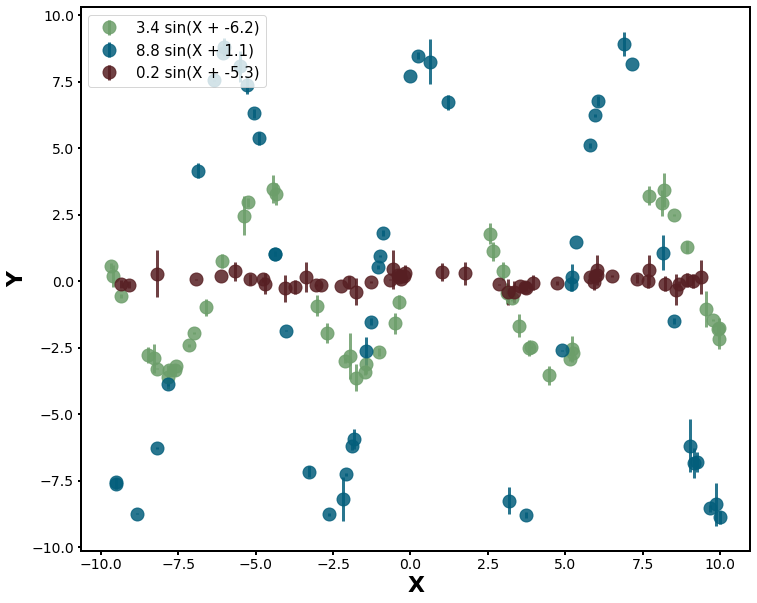

In [9]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 10))

for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(2)

ax1.tick_params(width=2)

colors = [['#95C623', '#6C9E6A'], ['#90A8C3', '#035E7B'], ['#801810', '#571F23']]
sampleX, sampleY, sampleW = (), (), ()

for i in range(len(C)):
    X = np.array([[np.random.uniform(low=-10, high=10) for x in range(50)]])
    noise = np.random.normal(size=(len(X[0])))/6
    Y = func(X[0], *C[i]) + noise
        
    plt.errorbar(X[0], Y, yerr=2*noise, fmt='o', color = colors[i][1],alpha=0.85,\
                 markersize=13, elinewidth=3, label = f'{C[i][0]:.1f} sin(X + {C[i][1]:.1f})')
    
    sampleX += (X.T,)
    sampleY += (Y,)
    sampleW += (abs(noise),)

plt.xlabel('X', fontsize = 22, fontweight="bold")
plt.ylabel('Y', fontsize = 22, fontweight="bold")
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize = 15, loc='upper left')

### Standard GPlearn parameters

In [32]:
const_range = None
population_size=50
generations=5
parsimony_coefficient = 10
verbose = 1
tournament_size=10
stopping_criteria = 1

function_set = ['add', 'mul','sub','div', 'sin']

p_crossover=0.3
p_subtree_mutation=0.25
p_hoist_mutation=0.2
p_point_mutation=0.25

### MvSR parameters

Let us suppose that the user understands -- after carefully examining the examples -- that there is a translation symmetry along the X axis. However he misses the scaling invariance along the Y axis. In addition to that symmetry he supposes that the data can be describe with at most two additionnal free parameters.

In [40]:
# Number of free parameters allowed by the user (excluding symmetry parameters)
n_free = 2

# Input the known symmetries. add == translation invariances ; mul == scaling invariances
addX = True
mulX, addY, mulY = False, False, False

# Put limit to free parameters (including symmetry parameters)
free_lim = (-10, 10)

# If true, you can directly input an uncertainty vector as weights. 
wisunc = True

# metric is a gplearn parmeter. However the 'bic' option is specific to MvSR.
# Uses Bayesian Information Criterion as metric. Apply penality to equation with more free parameters
metric='bic'

In [41]:
gp = SymbolicRegressor(population_size=population_size, function_set=function_set,
                       generations=generations, parsimony_coefficient=parsimony_coefficient,
                       p_crossover=p_crossover, p_subtree_mutation=p_subtree_mutation,
                       p_hoist_mutation=p_hoist_mutation, p_point_mutation=p_point_mutation,
                       random_state=42, verbose=verbose, metric=metric, const_range=const_range,
                       stopping_criteria=stopping_criteria, n_free=n_free, free_lim=free_lim,
                       addX=addX, mulX=mulX, addY=addY, mulY=mulY, wisunc=wisunc)
    

gp.fit(sampleX, sampleY, sample_weight=sampleW)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    19.70           333812        6          1.24724              N/A     18.91s
   1    33.60          51907.6        6          1.24724              N/A     24.36s
   2     8.34          50861.4        6          1.13976              N/A      3.31s
   3     6.12          36348.3       10          1.13975              N/A      1.51s
   4     6.68          35512.3        4          1.13976              N/A      0.00s
Best fitted parametric values :
[<ValueView C0=3.3822677087617308 C1=1.0 addX0=0.08640492152858054>
 <ValueView C0=8.800418238367298 C1=1.0 addX0=1.099697583545828>
 <ValueView C0=0.19894722979344967 C1=1.0 addX0=-5.297889621536683>]


SymbolicRegressor(addX=(True,), const_range=None, free_lim=(-10, 10),
                  function_set=['add', 'mul', 'sub', 'div', 'sin'],
                  generations=5, metric='bic', mulX=(False,), n_free=2,
                  p_crossover=0.3, p_hoist_mutation=0.2, p_point_mutation=0.25,
                  p_subtree_mutation=0.25, parsimony_coefficient=10,
                  population_size=50, random_state=42, stopping_criteria=1,
                  verbose=1, wisunc=True)

### Result

In [42]:
# Print the mathematical equation of the function
sympify((str(gp._program)), locals=converter)

C0*sin(X0)

Failure ? No because sympify will not print the translation symmetry that was inputed by the user. Therefore one should manually transform X to (X+C1). In this case we recover exaclty the original function, success !
The bic metric uses a chi square plus a penalty proportional to the number free parameters used in the equation. And we notice that even if the user allowed for 2 free parameters, only one was used.